In [113]:
import pandas as pd 
import numpy as np 
df1=pd.read_csv('./movies_metadata.csv')

In [114]:
df1.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [115]:
df1.drop(["belongs_to_collection","homepage","imdb_id","revenue","spoken_languages","status","tagline","original_title","video","popularity","poster_path","production_companies","production_countries"],axis=1,inplace=True)
df1.dropna()

,adult,budget,genres,id,original_language,overview,release_date,runtime,title,vote_average,vote_count
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,"Led by Woody, Andy's toys live happily in his ...",1995-10-30,81.0,Toy Story,7.7,5415.0
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,When siblings Judy and Peter discover an encha...,1995-12-15,104.0,Jumanji,6.9,2413.0
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,A family wedding reignites the ancient feud be...,1995-12-22,101.0,Grumpier Old Men,6.5,92.0
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,"Cheated on, mistreated and stepped on, the wom...",1995-12-22,127.0,Waiting to Exhale,6.1,34.0
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",11862,en,Just when George Banks has recovered from his ...,1995-02-10,106.0,Father of the Bride Part II,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...
45460,False,0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",30840,en,"Yet another version of the classic epic, with ...",1991-05-13,104.0,Robin Hood,5.7,26.0
45462,False,0,"[{'id': 18, 'name': 'Drama'}]",111109,tl,An artist struggles to finish his work while a...,2011-11-17,360.0,Century of Birthing,9.0,3.0
45463,False,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",67758,en,"When one of her hits goes wrong, a professiona...",2003-08-01,90.0,Betrayal,3.8,6.0
45464,False,0,[],227506,en,"In a small town live two brothers, one a minis...",1917-10-21,87.0,Satan Triumphant,0.0,0.0


In [116]:
df1 = df1.replace(0, np.nan).dropna(axis=0, how='any', subset=["vote_count","overview"])

<Axes: xlabel='vote_average'>

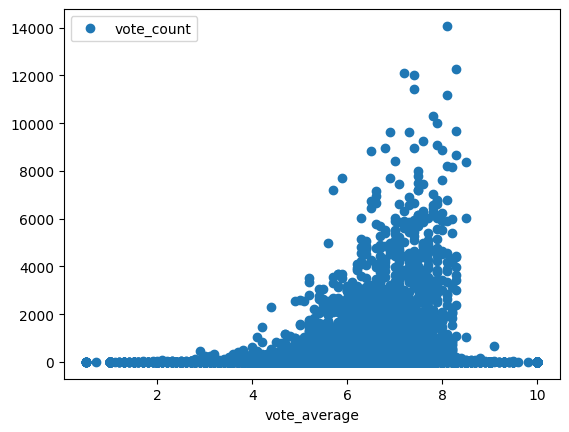

In [117]:
df1.plot(x='vote_average', y='vote_count', style='o')

In [118]:
C= df1['vote_average'].mean()
m= df1['vote_count'].quantile(0.7)
movies = df1.copy().loc[df1['vote_count'] >= 1000]
movies.shape

(1121, 11)

(1121, 11)

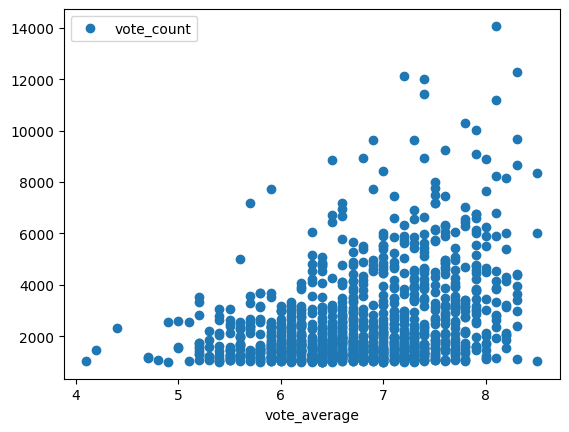

In [119]:
movies.plot(x='vote_average', y='vote_count', style='o')
movies.shape

In [120]:

def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

movies['score'] = movies.apply(weighted_rating, axis=1)
movies = movies.sort_values('score', ascending=False)
top_movies = movies.head(100)

In [121]:
top_movies

,adult,budget,genres,id,original_language,overview,release_date,runtime,title,vote_average,vote_count,score
314,False,25000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",278,en,Framed in the 1940s for the double murder of h...,1994-09-23,142.0,The Shawshank Redemption,8.5,8358.0,8.491414
834,False,6000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",238,en,"Spanning the years 1945 to 1955, a chronicle o...",1972-03-14,175.0,The Godfather,8.5,6024.0,8.488103
40251,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 16, ...",372058,ja,High schoolers Mitsuha and Taki are complete s...,2016-08-26,106.0,Your Name.,8.5,1030.0,8.432001
12481,False,185000000,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",155,en,Batman raises the stakes in his war on crime. ...,2008-07-16,152.0,The Dark Knight,8.3,12269.0,8.294616
2843,False,63000000,"[{'id': 18, 'name': 'Drama'}]",550,en,A ticking-time-bomb insomniac and a slippery s...,1999-10-15,139.0,Fight Club,8.3,9678.0,8.293179
...,...,...,...,...,...,...,...,...,...,...,...,...
24982,False,15000000,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",266856,en,The Theory of Everything is the extraordinary ...,2014-11-26,123.0,The Theory of Everything,7.8,3403.0,7.784933
40416,False,40000000,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",324786,en,"WWII American Army Medic Desmond T. Doss, who ...",2016-10-07,140.0,Hacksaw Ridge,7.8,3294.0,7.784439
13187,False,33000000,"[{'id': 18, 'name': 'Drama'}]",13223,en,Walt Kowalski is a widower who holds onto his ...,2008-12-09,116.0,Gran Torino,7.8,3181.0,7.783891
12083,False,15000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 18, '...",5915,en,"The true story of top student and athlete, Chr...",2007-09-11,148.0,Into the Wild,7.8,3139.0,7.783677


In [125]:
import ast
def splitGenres(x):
    biglist = []
    x = ast.literal_eval(x)
    for elem in x:
        biglist.append(elem["name"])
    return biglist
movies["genres"] = movies["genres"].apply(splitGenres)
top_movies["genres"] = top_movies["genres"].apply(splitGenres)
movies

ValueError: malformed node or string: ['Drama', 'Crime']

In [126]:
g_movies = movies.explode("genres")
g_movies

,adult,budget,genres,id,original_language,overview,release_date,runtime,title,vote_average,vote_count,score
314,False,25000000,Drama,278,en,Framed in the 1940s for the double murder of h...,1994-09-23,142.0,The Shawshank Redemption,8.5,8358.0,8.491414
314,False,25000000,Crime,278,en,Framed in the 1940s for the double murder of h...,1994-09-23,142.0,The Shawshank Redemption,8.5,8358.0,8.491414
834,False,6000000,Drama,238,en,"Spanning the years 1945 to 1955, a chronicle o...",1972-03-14,175.0,The Godfather,8.5,6024.0,8.488103
834,False,6000000,Crime,238,en,"Spanning the years 1945 to 1955, a chronicle o...",1972-03-14,175.0,The Godfather,8.5,6024.0,8.488103
40251,False,0,Romance,372058,ja,High schoolers Mitsuha and Taki are complete s...,2016-08-26,106.0,Your Name.,8.5,1030.0,8.432001
...,...,...,...,...,...,...,...,...,...,...,...,...
26563,False,120000000,Science Fiction,166424,en,Four young outsiders teleport to a dangerous u...,2015-08-05,100.0,Fantastic Four,4.4,2322.0,4.419944
1491,False,125000000,Action,415,en,Along with crime-fighting partner Robin and ne...,1997-06-20,125.0,Batman & Robin,4.2,1447.0,4.235697
1491,False,125000000,Crime,415,en,Along with crime-fighting partner Robin and ne...,1997-06-20,125.0,Batman & Robin,4.2,1447.0,4.235697
1491,False,125000000,Fantasy,415,en,Along with crime-fighting partner Robin and ne...,1997-06-20,125.0,Batman & Robin,4.2,1447.0,4.235697


<Axes: xlabel='genres'>

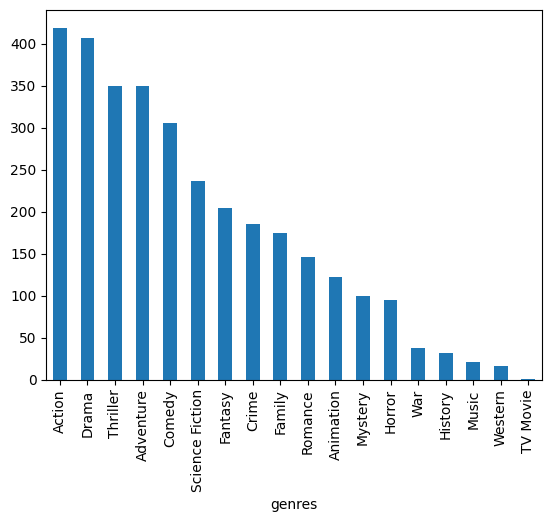

In [129]:
g_movies.genres.value_counts()
g_movies.genres.value_counts().plot(kind='bar')

<Axes: xlabel='genres'>

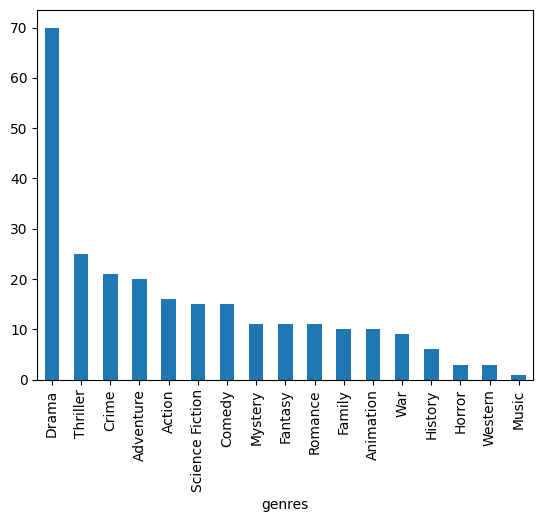

In [130]:
top_movies = top_movies.explode("genres")
top_movies.genres.value_counts().plot(kind='bar')

In [51]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku 
import pandas as pd
import numpy as np
import string, os 
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
#longpath problem
all_descriptions = list(movies.overview.values)
len(all_descriptions)

419

In [52]:
corpus = [x for x in all_descriptions]
corpus = corpus[0:100]
corpus[0]


'Framed in the 1940s for the double murder of his wife and her lover, upstanding banker Andy Dufresne begins a new life at the Shawshank prison, where he puts his accounting skills to work for an amoral warden. During his long stretch in prison, Dufresne comes to be admired by the other inmates -- including an older prisoner named Red -- for his integrity and unquenchable sense of hope.'

In [24]:
t = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token=None, document_count=0)
t.fit_on_texts(corpus)
print(t.word_counts)
print(t.word_docs)
print(t.document_count)
print(t.word_index)
print('Found %s unique tokens.' % len(t.word_index))

OrderedDict([('using', 1), ('interviews', 2), ('and', 186), ('other', 10), ('footage', 6), ('shot', 3), ('especially', 1), ('for', 34), ('this', 20), ('documentary', 7), ('french', 1), ('director', 3), ('claude', 2), ('lanzmann', 1), ('investigates', 1), ('the', 316), ('state', 3), ('of', 176), ('israel', 1), ('in', 128), ('1972', 1), ('movie', 3), ('concentrates', 1), ('on', 52), ('israelis', 1), ('going', 2), ('about', 17), ('their', 37), ('business', 3), ('everyday', 1), ('living', 2), ('a', 200), ('most', 11), ('perfect', 2), ('picture', 2), ('pan', 1), ('american', 9), ('exposition', 1), ('buildings', 1), ('including', 1), ('electric', 1), ('tower', 1), ('temple', 1), ('music', 5), ('as', 30), ('they', 32), ('appear', 2), ('at', 26), ('night', 3), ('tim', 2), ('tucker', 1), ('dylan', 1), ('bruce', 2), ('was', 11), ('star', 3), ('forward', 1), ('who', 32), ('broke', 1), ('knee', 1), ('never', 4), ('got', 2), ('drafted', 1), ('to', 145), ('nhl', 1), ('after', 10), ('injury', 1), ('l

In [25]:
# Tokenization
t = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token=None, document_count=0)

def get_sequence_of_tokens(corpus):
    t.fit_on_texts(corpus)
    total_words = len(t.word_index) + 1
    
    input_sequences = []
    for line in corpus:
        token_list = t.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
            
    return input_sequences, total_words
input_sequences, total_words = get_sequence_of_tokens(corpus)
input_sequences[:10]

[[607, 290],
 [607, 290, 3],
 [607, 290, 3, 46],
 [607, 290, 3, 46, 86],
 [607, 290, 3, 46, 86, 186],
 [607, 290, 3, 46, 86, 186, 608],
 [607, 290, 3, 46, 86, 186, 608, 14],
 [607, 290, 3, 46, 86, 186, 608, 14, 22],
 [607, 290, 3, 46, 86, 186, 608, 14, 22, 69],
 [607, 290, 3, 46, 86, 186, 608, 14, 22, 69, 609]]

In [26]:
# pad sequences 
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen = max_sequence_len, padding = 'pre'))
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes = total_words)
    
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(input_sequences)

In [27]:
def create_model(max_sequence_len, total_words):
    model = Sequential()
    
    # Add Input Embedding Layer
    model.add(Embedding(total_words, 10, input_length=max_sequence_len - 1))
    
    # Add Hidden Layer 1 - LSTM Layer
    model.add(LSTM(100))
    model.add(Dropout(0.1))
    
    # Add Output Layer
    model.add(Dense(total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

model = create_model(max_sequence_len, total_words)
model.summary()

model.fit(predictors, label, epochs=200, verbose=5)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 161, 10)           21640     
                                                                 
 lstm_1 (LSTM)               (None, 100)               44400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 2164)              218564    
                                                                 
Total params: 284604 (1.09 MB)
Trainable params: 284604 (1.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200
Epoch 11/200
Epoch 12/200
Epo

In [28]:
def generate_text(seed_text, next_words, model, max_seq_len):
    for _ in range(next_words):
        token_list = t.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding='pre')
        
        #predicted = model.predict_classes(token_list, verbose=0)
        predict_x=model.predict(token_list, verbose=0) 
        classes_x=np.argmax(predict_x,axis=1)
        
        output_word = ''
        
        for word,index in t.word_index.items():
            if index == classes_x:
                output_word = word
                break
                
        seed_text = seed_text + " " + output_word
        
    return seed_text.title()

In [34]:
print(generate_text("The", 100, model, max_sequence_len))

The Inuit Of Belcher Islands Struggle To Adapt As Their Environment Changes To The Star For A Meek Report He He'S An Annoying Habit Of Going Through A Rather Drastic Change Every Full Moon Who Her Looking For Once To His Own To When They Both From Be They Have Suffered As The Slums Of Mauritius And Were Leads His Dvd And Is What For A Man Who'S Come To Wive It Wealthily In Padua And Petruchio Marries Kate With A Plan To Tame Her While Everybody Else Begins Scheming To Win Bianca'S Hand Up With The Other They Are An
